<font size="+3"><strong>Stock Market Prediction using Numerical and Textual Analysis</strong></font>

# **Overview**

Develop a hybrid model for stock price prediction by analyzing historical stock prices numerically and news headline sentiments, focusing on SENSEX (S&P BSE SENSEX).

# **Datasets**

* [Historic stock prices](https://finance.yahoo.com/quote/%5EBSESN/history/)
* [Textual (news) dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH)

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
import inspect
import time
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# **Historical Stock Prices Dataset**

## **1. Prepare Data**

### **1.1 Import**

In [ ]:
# Import historical stock prices dataset into a dataframe
df_price = yf.download('^BSESN', start='2010-01-01')  # Use '^BSESN' for SENSEX index

print(df_price.shape)
print(df_price.info())
df_price.head()

[*********************100%%**********************]  1 of 1 completed

(3569, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3569 entries, 2010-01-04 to 2024-07-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3569 non-null   float64
 1   High       3569 non-null   float64
 2   Low        3569 non-null   float64
 3   Close      3569 non-null   float64
 4   Adj Close  3569 non-null   float64
 5   Volume     3569 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 195.2 KB
None


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,17473.449219,17582.839844,17378.380859,17558.730469,17558.730469,28200
2010-01-05,17555.769531,17729.779297,17555.769531,17686.240234,17686.240234,27000
2010-01-06,17719.470703,17790.330078,17636.710938,17701.130859,17701.130859,21400
2010-01-07,17701.970703,17733.339844,17566.539062,17615.720703,17615.720703,18000
2010-01-08,17603.869141,17658.119141,17508.960938,17540.289062,17540.289062,17200


### **1.2 Explore**

In [ ]:
df_price.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

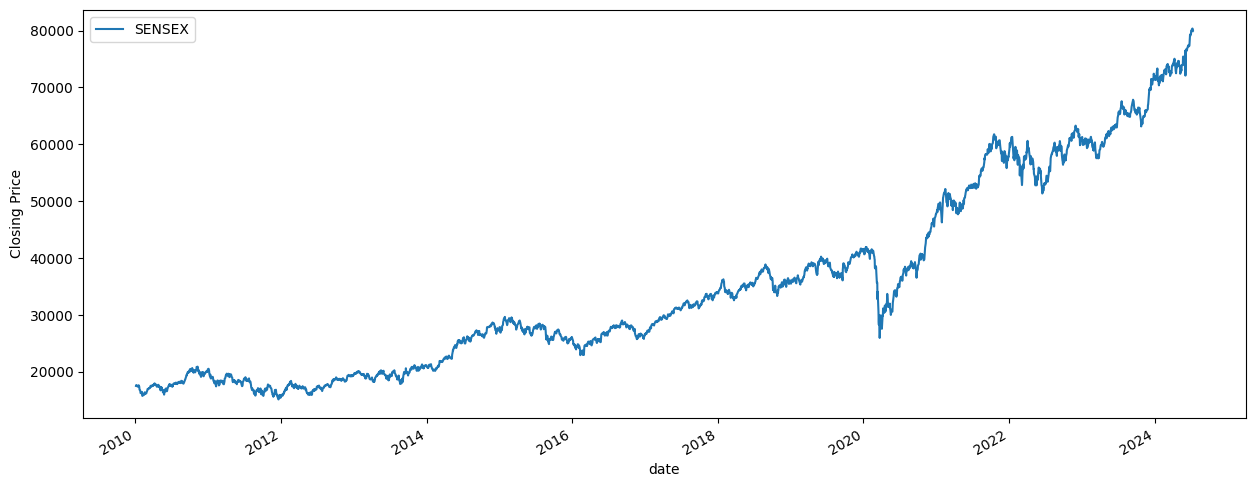

In [ ]:
#Plot the closing price of df_price

fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_price` closing price
df_price["Close"].plot(ax=ax, label="SENSEX")

# Label axes
plt.xlabel("date")
plt.ylabel("Closing Price")

# Add legend
plt.legend();

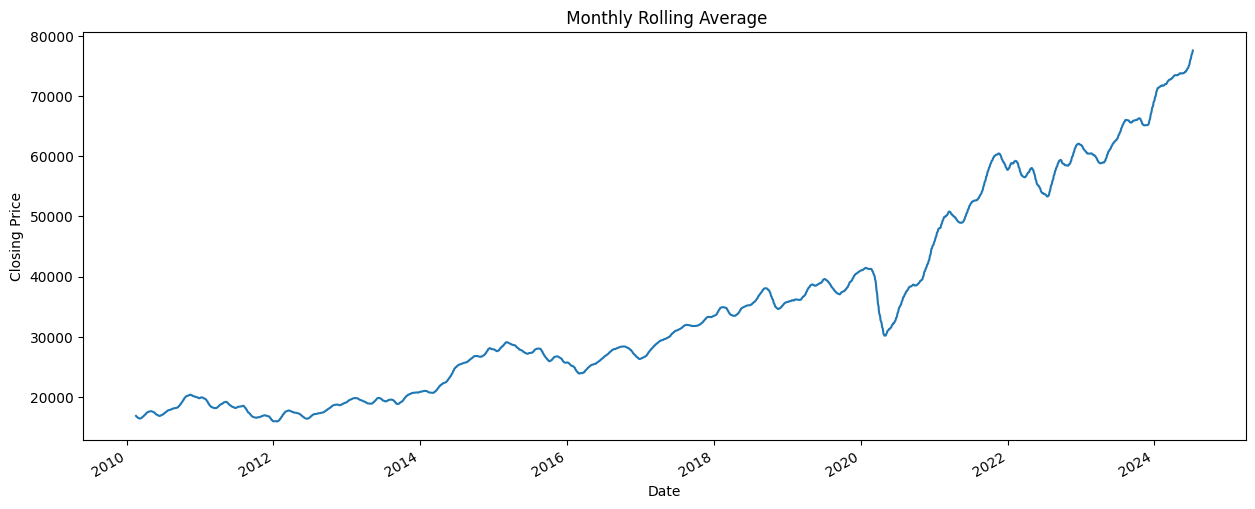

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
df_price["Close"].rolling(30).mean().plot(ax= ax, ylabel="Closing Price", title=" Monthly Rolling Average");

In [ ]:
# Create "return" column
df_price["Return"] = df_price["Close"].pct_change() * 100
df_price.dropna(inplace=True)
print("df_price shape:", df_price.shape)
print(df_price.info())
df_price.head()

df_price shape: (3568, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3568 entries, 2010-01-05 to 2024-07-11
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3568 non-null   float64
 1   High       3568 non-null   float64
 2   Low        3568 non-null   float64
 3   Close      3568 non-null   float64
 4   Adj Close  3568 non-null   float64
 5   Volume     3568 non-null   int64  
 6   Return     3568 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 223.0 KB
None


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2010-01-05,17555.769531,17729.779297,17555.769531,17686.240234,17686.240234,27000,0.726190
2010-01-06,17719.470703,17790.330078,17636.710938,17701.130859,17701.130859,21400,0.084193
2010-01-07,17701.970703,17733.339844,17566.539062,17615.720703,17615.720703,18000,-0.482512
2010-01-08,17603.869141,17658.119141,17508.960938,17540.289062,17540.289062,17200,-0.428206
2010-01-11,17724.589844,17776.570312,17500.789062,17526.710938,17526.710938,18400,-0.077411


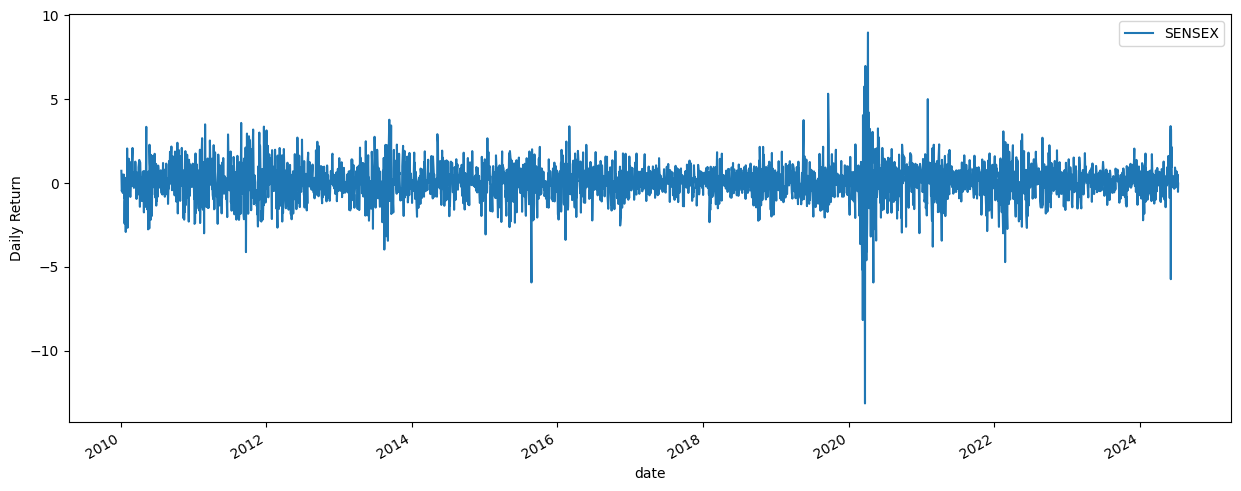

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot returns for `df_price`
df_price["Return"].plot(ax=ax, label="SENSEX")

# Label axes
plt.xlabel("date")
plt.ylabel("Daily Return")


# Add legend
plt.legend();

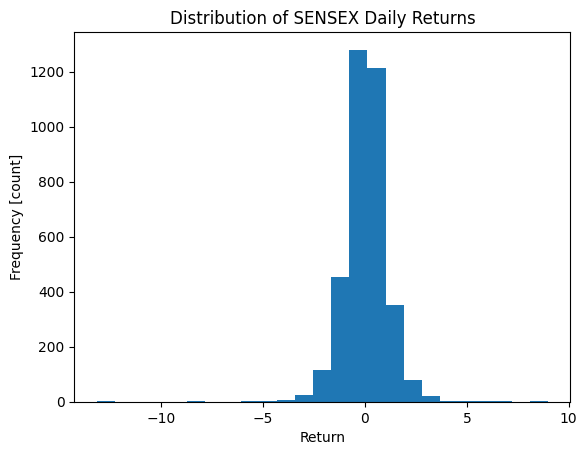

In [ ]:
# Create histogram of `y_tesco`, 25 bins
plt.hist(df_price["Return"], bins=25)

# Add axis labels
plt.xlabel("Return")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of SENSEX Daily Returns");

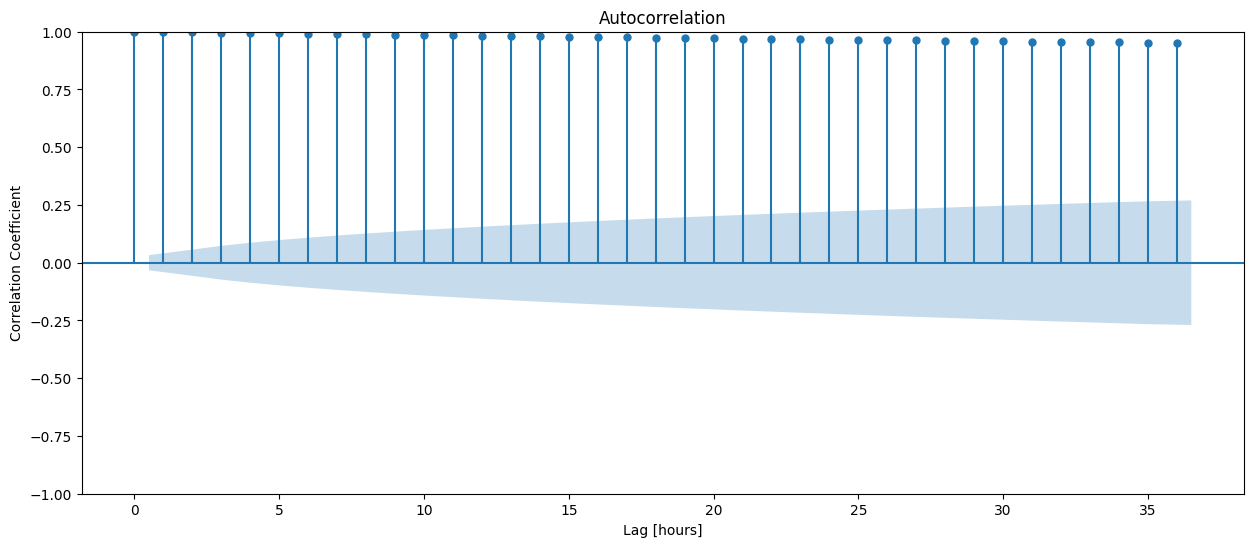

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df_price["Close"], ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

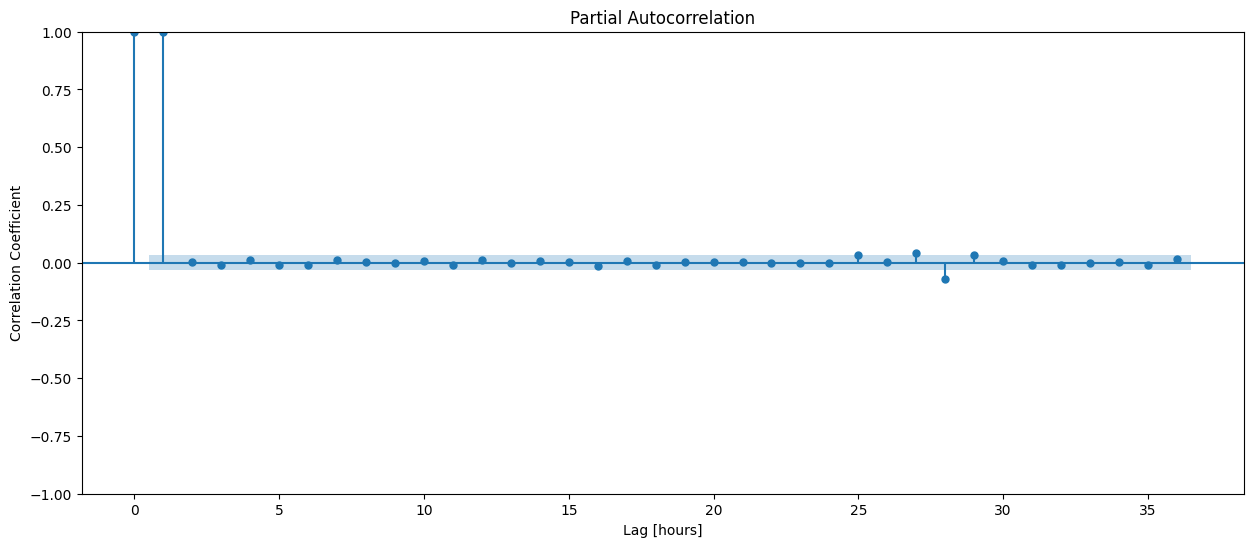

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df_price["Close"], ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

### **1.3 Split**

In [ ]:
y = df_price["Close"]
y

Date
2010-01-05    17686.240234
2010-01-06    17701.130859
2010-01-07    17615.720703
2010-01-08    17540.289062
2010-01-11    17526.710938
                  ...     
2024-07-05    79996.601562
2024-07-08    79960.382812
2024-07-09    80351.640625
2024-07-10    79924.773438
2024-07-11    79897.343750
Name: Close, Length: 3568, dtype: float64

In [ ]:
cutoff_test = int(len(y) * 0.85)
y_train = y.iloc[: cutoff_test]
y_test = y.iloc[cutoff_test : ]

## **2. Build Model**

### **2.1 Baseline**

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_train, y_pred_baseline))
print("Mean Stock Price:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))
print("Baseline RMSE:", round(rmse_baseline, 2))

Mean Stock Price: 29822.63
Baseline MAE: 9328.61
Baseline RMSE: 11606.71


### **2.2 Iterate**

In [ ]:
p_params = range(0,25,8)
q_params = range(0,3,1)

In [ ]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
      # Create key-value pair in dict. Key is `p`, value is empty list.
      mae_grid[p] = list()
      # Inner loop: Iterate through possible values for `q`
      for q in q_params:
           # Combination of hyperparameters for model
           order = (p, 0, q)
           # Note start time
           start_time = time.time()
           # Train model
           model = model = sm.tsa.arima.ARIMA(y_train, order=order).fit()
           # Calculate model training time
           elapsed_time = round(time.time() - start_time, 2)
           print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
           # Generate in-sample (training) predictions
           y_pred = model.predict()
           # Calculate training MAE
           mae = mean_absolute_error(y_train, y_pred)
           # Append MAE to list in dictionary
           mae_grid[p].append(mae)


print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.17 seconds.
Trained ARIMA (0, 0, 1) in 4.6 seconds.
Trained ARIMA (0, 0, 2) in 11.34 seconds.
Trained ARIMA (8, 0, 0) in 32.88 seconds.
Trained ARIMA (8, 0, 1) in 21.07 seconds.
Trained ARIMA (8, 0, 2) in 24.93 seconds.
Trained ARIMA (16, 0, 0) in 8.43 seconds.
Trained ARIMA (16, 0, 1) in 9.57 seconds.
Trained ARIMA (16, 0, 2) in 48.84 seconds.
Trained ARIMA (24, 0, 0) in 27.0 seconds.
Trained ARIMA (24, 0, 1) in 80.07 seconds.
Trained ARIMA (24, 0, 2) in 110.39 seconds.

{0: [9328.612071071584, 4743.139179590133, 3500.364351451793], 8: [249.8692291188709, 231.26820580698106, 231.3605103266392], 16: [230.89545119364604, 230.91842439384337, 231.37628977345219], 24: [230.95067792151116, 231.10550058223433, 231.18728889824575]}


In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,9328.6121,249.8692,230.8955,230.9507
1,4743.1392,231.2682,230.9184,231.1055
2,3500.3644,231.3605,231.3763,231.1873


In [ ]:
min_mae = float('inf')
min_index = None  # Initialize index tracker

for p, maes in mae_grid.items():
    for i, mae in enumerate(maes):
        if mae < min_mae:
            min_mae = mae
            min_index = (p, i)  # Store p and index within maes

print("Minimum MAE:", min_mae)
print("Index of minimum MAE:", min_index)

Minimum MAE: 230.89545119364604
Index of minimum MAE: (16, 0)


### **2.3 Evaluate**

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()

for i in range(len(y_test)):
    model = sm.tsa.arima.ARIMA(history, order=(16,0,0)).fit()
    next_pred = model.forecast()
    next_pred_index = next_pred.index[0]
    y_pred_wfv = y_pred_wfv._append(next_pred)
    history = history._append(pd.Series({next_pred_index: y_test.iloc[i]}))


test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_wfv))
print('Test RMSE (walk forward validation):', round(test_rmse,2))
R2_score = r2_score(y_test, y_pred_wfv)
print('R2 Score:', round(R2_score,2))

Test MAE (walk forward validation): 373.24
Test RMSE (walk forward validation): 542.1
R2 Score: 0.99


## **3. Results**

In [ ]:
df_predictions = pd.DataFrame({"y_test": y_test,"y_pred_wfv": y_pred_wfv})
df_predictions.head()

,y_test,y_pred_wfv
Date,,
2023-03-16,57634.839844,57480.382588
2023-03-17,57989.898438,57567.045312
2023-03-20,57628.949219,57918.122982
2023-03-21,58074.679688,57608.189761
2023-03-22,58214.589844,58017.315587


In [ ]:
fig = px.line(df_predictions, labels = {"value": " Close Price"}, title='ARMA Model: Actual Prices vs. Predicted Prices')
fig.show()

# **News Headline Sentiments**

## **1. Prepare Data**

### **1. Import**

In [ ]:
# Import textual news dataset into a dataframe
df_news = pd.read_csv("india-news-headlines.csv")
print(df_news.shape)
print(df_news.info())
df_news.head()

(2057551, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057551 entries, 0 to 2057550
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 47.1+ MB
None


,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


### **1.2 Explore**

In [ ]:
# Rename the columns
df_news.columns=['Date','Category','News']

In [ ]:
# Drop unnecessary columns
df_news.drop(columns='Category', inplace=True)

In [ ]:
# Correct date formatting, handling missing days
df_news["Date"] = pd.to_datetime(df_news["Date"], format='%Y%m%d', errors='coerce')

# Check for missing values after conversion
print(df_news["Date"].isna().sum())

1


In [ ]:
# Group the headlines for each day
df_news['News'] = df_news.groupby(['Date'])['News'].transform(lambda x: ' '.join(x.astype(str)))
df_news = df_news.drop_duplicates()

In [ ]:
# Removing unwanted characters from the News
df_news.dropna(inplace=True)
df_news.replace("[^a-zA-Z']"," ", regex=True, inplace=True)
df_news["News"].head()

0      win over cena satisfying but defeating underta...
1      Status quo will not be disturbed at Ayodhya  s...
87     Powerless north India gropes in the dark Think...
128    The string that pulled Stephen Hawking to Indi...
281    Light combat craft takes India into club class...
Name: News, dtype: object

In [ ]:
# Missing values
df_news.isnull().sum()

Date    0
News    0
dtype: int64

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5150 entries, 0 to 2057550
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5149 non-null   datetime64[ns]
 1   News    5149 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 120.7+ KB


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  if isinstance(text, str): # Check if the input is a string
    return TextBlob(text).sentiment.subjectivity
  else:
    return None # Or handle non-string values as needed

def getPolarity(text):
  if isinstance(text, str): # Check if the input is a string
    return  TextBlob(text).sentiment.polarity
  else:
    return None # Or handle non-string values as needed

# Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)

In [ ]:
# Convert the 'News' column to string type before applying sentiment analysis
df_news['News'] = df_news['News'].astype(str)

#Adding sentiment score to news
sentiment_int = SentimentIntensityAnalyzer()
df_news['Compound'] = [sentiment_int.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sentiment_int.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sentiment_int.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sentiment_int.polarity_scores(v)['pos'] for v in df_news['News']]

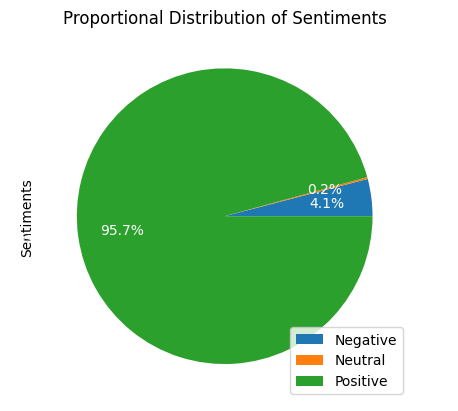

In [ ]:
# Plotting the proportional distribution of sentiments
plt.pie(x=[len(df_news[df_news['Polarity'] < 0]),
           len(df_news[df_news['Polarity'] == 0]),
           len(df_news[df_news['Polarity'] > 0])],
        labels=['Negative', 'Neutral', 'Positive'],
        autopct='%1.1f%%',
        pctdistance=0.7,
        textprops={'fontsize':10, 'color':'white'}
)
plt.ylabel('Sentiments')
plt.title('Proportional Distribution of Sentiments')
plt.legend(loc='lower right');

###**1.3 Final Dataset**

In [ ]:
#concatenate dataframes along the rows
result = pd.merge(df_price, df_news, on=['Date'])
result.head()

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2010-01-04,17473.449219,17582.839844,17378.380859,17558.730469,17558.730469,28200,Bebo Khan't stop loving Chor Bazaari top song ...,0.469111,0.051662,-0.9993,0.151,0.741,0.108
1,2010-01-05,17555.769531,17729.779297,17555.769531,17686.240234,17686.240234,27000,Women say no to one-night stands MJ's new trac...,0.418044,0.011382,-0.9996,0.144,0.780,0.076
2,2010-01-06,17719.470703,17790.330078,17636.710938,17701.130859,17701.130859,21400,Are ladies really THIS safe on Nagpur's buses?...,0.426226,0.053593,-0.9996,0.153,0.752,0.095
3,2010-01-07,17701.970703,17733.339844,17566.539062,17615.720703,17615.720703,18000,Dev Patel meets the Pintos Rahman's going gree...,0.404291,0.037038,-0.9998,0.180,0.719,0.101
4,2010-01-08,17603.869141,17658.119141,17508.960938,17540.289062,17540.289062,17200,Points table Bicholim fire cell saved 79 lives...,0.379068,0.032007,-0.9999,0.174,0.732,0.094


In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1278 non-null   datetime64[ns]
 1   Open          1278 non-null   float64       
 2   High          1278 non-null   float64       
 3   Low           1278 non-null   float64       
 4   Close         1278 non-null   float64       
 5   Adj Close     1278 non-null   float64       
 6   Volume        1278 non-null   int64         
 7   News          1278 non-null   object        
 8   Subjectivity  1278 non-null   float64       
 9   Polarity      1278 non-null   float64       
 10  Compound      1278 non-null   float64       
 11  Negative      1278 non-null   float64       
 12  Neutral       1278 non-null   float64       
 13  Positive      1278 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1), object(1)
memory usage: 139.9+ KB


In [ ]:
df_final = result[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
df_final.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,17558.730469,0.469111,0.051662,-0.9993,0.151,0.741,0.108
1,17686.240234,0.418044,0.011382,-0.9996,0.144,0.780,0.076
2,17701.130859,0.426226,0.053593,-0.9996,0.153,0.752,0.095
3,17615.720703,0.404291,0.037038,-0.9998,0.180,0.719,0.101
4,17540.289062,0.379068,0.032007,-0.9999,0.174,0.732,0.094


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1278 non-null   float64
 1   Subjectivity  1278 non-null   float64
 2   Polarity      1278 non-null   float64
 3   Compound      1278 non-null   float64
 4   Negative      1278 non-null   float64
 5   Neutral       1278 non-null   float64
 6   Positive      1278 non-null   float64
dtypes: float64(7)
memory usage: 70.0 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df_final))
df.columns = df_final.columns
df.index = df_final.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.164314,0.790403,0.349039,0.00035,0.492424,0.412791,0.418182
1,0.173104,0.489746,0.111794,0.00020,0.439394,0.639535,0.127273
2,0.174130,0.537922,0.360413,0.00020,0.507576,0.476744,0.300000
3,0.168242,0.408780,0.262903,0.00010,0.712121,0.284884,0.354545
4,0.163043,0.260280,0.233271,0.00005,0.666667,0.360465,0.290909


###**1.4 Split**

In [ ]:
X=df.drop('Close',axis=1)
y=df['Close']

In [ ]:
from sklearn.model_selection import train_test_split

X=df.drop('Close',axis=1)
y=df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) # Split the data into training and testing sets

## **2. Build Models**

### **2.1. Iterate**

In [ ]:
# Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_linear = r2_score(y_test, y_pred)
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear)
print("R-squared:", r2_linear)
print("Mean Squared Error:", rmse_linear)

R-squared: 0.07843517566384539
Mean Squared Error: 0.23532870806260053


In [ ]:
model=Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_Ridge = r2_score(y_test, y_pred)
mse_Ridge = mean_squared_error(y_test, y_pred)
rmse_Ridge = np.sqrt(mse_Ridge)
print("R-squared:", r2_Ridge)
print("Root Mean Squared Error:", rmse_Ridge)

R-squared: 0.07789478568070485
Root Mean Squared Error: 0.23539769433259033


In [ ]:
model=Lasso()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_Lasso = r2_score(y_test, y_pred)
mse_Lasso = mean_squared_error(y_test, y_pred)
rmse_Lasso = np.sqrt(mse_Lasso)
print("R-squared:", r2_Lasso)
print("Root Mean Squared Error:", rmse_Lasso)

R-squared: -0.0019362325698137894
Root Mean Squared Error: 0.24537595722391156


In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
predictions = dtr.predict(X_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

Mean Squared error:  0.10766415232831278


In [ ]:
model=ElasticNet()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_ElasticNet = r2_score(y_test, y_pred)
mse_ElasticNet = mean_squared_error(y_test, y_pred)
rmse_ElasticNet = np.sqrt(mse_ElasticNet)
print("R-squared:", r2_ElasticNet)
print("Root Mean Squared Error:", rmse_ElasticNet)

R-squared: -0.0019362325698137894
Root Mean Squared Error: 0.24537595722391156


In [ ]:
model=DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_DecisionTreeRegressor = r2_score(y_test, y_pred)
mse_DecisionTreeRegressor = mean_squared_error(y_test, y_pred)
rmse_DecisionTreeRegressor = np.sqrt(mse_DecisionTreeRegressor)
print("R-squared:", r2_DecisionTreeRegressor)
print("Root Mean Squared Error:", rmse_DecisionTreeRegressor)

R-squared: -0.7726859748026143
Root Mean Squared Error: 0.32638325559966547


In [ ]:
model=TweedieRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_TweedieRegressor = r2_score(y_test, y_pred)
mse_TweedieRegressor = mean_squared_error(y_test, y_pred)
rmse_TweedieRegressor = np.sqrt(mse_TweedieRegressor)
print("R-squared:", r2_TweedieRegressor)
print("Root Mean Squared Error:", rmse_TweedieRegressor)

R-squared: 0.002440289385065797
Root Mean Squared Error: 0.24483946173347257


In [ ]:
model=RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_RandomForestRegressor = r2_score(y_test, y_pred)
mse_RandomForestRegressor = mean_squared_error(y_test, y_pred)
rmse_RandomForestRegressor = np.sqrt(mse_RandomForestRegressor)
print("R-squared:", r2_RandomForestRegressor)
print("Root Mean Squared Error:", rmse_RandomForestRegressor)
print('Mean Squared error: ',mean_squared_error(y_pred,y_test))

R-squared: 0.1691861722440935
Root Mean Squared Error: 0.22344149262139978
Mean Squared error:  0.04992610062487905


In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
print(mean_squared_error(predictions, y_test))

0.057444355083846266


In [ ]:
model=GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_GradientBoostingRegressor = r2_score(y_test, y_pred)
mse_GradientBoostingRegressor = mean_squared_error(y_test, y_pred)
rmse_GradientBoostingRegressor = np.sqrt(mse_GradientBoostingRegressor)
print("R-squared:", r2_GradientBoostingRegressor)
print("Root Mean Squared Error:", rmse_GradientBoostingRegressor)

R-squared: 0.15268246502489424
Root Mean Squared Error: 0.22564985709625152


In [ ]:
model=KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_KNeighborsRegressor = r2_score(y_test, y_pred)
mse_KNeighborsRegressor = mean_squared_error(y_test, y_pred)
rmse_KNeighborsRegressor= np.sqrt(mse_GradientBoostingRegressor)
print("R-squared:", r2_KNeighborsRegressor)
print("Root Mean Squared Error:", rmse_KNeighborsRegressor)

R-squared: -0.0578504894127192
Root Mean Squared Error: 0.22564985709625152


In [ ]:
model=xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("R-squared:", r2_xgb)
print("Root Mean Squared Error:", rmse_xgb)

R-squared: 0.04407586547231168
Root Mean Squared Error: 0.2396755204100875


In [ ]:
data = {
    "Model": ["Linear Regression", "Ridge", "Lasso", "ElasticNet", "TweedieRegressor",
              "DecisionTreeRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "XGBRegressor","KNeighborsRegressor"],
    "R-squared": [r2_linear, r2_Ridge, r2_Lasso, r2_ElasticNet, r2_TweedieRegressor,
                  r2_DecisionTreeRegressor, r2_RandomForestRegressor, r2_GradientBoostingRegressor, r2_xgb,r2_KNeighborsRegressor],
    "RMSE": [rmse_linear, rmse_Ridge, rmse_Lasso, rmse_ElasticNet, rmse_TweedieRegressor,
             rmse_DecisionTreeRegressor, rmse_RandomForestRegressor, rmse_GradientBoostingRegressor, rmse_xgb,rmse_KNeighborsRegressor]
}


df = pd.DataFrame(data)
df_sorted = df.sort_values(by="R-squared", ascending=False)
df_sorted

,Model,R-squared,RMSE
6,RandomForestRegressor,0.169186,0.223441
7,GradientBoostingRegressor,0.152682,0.225650
0,Linear Regression,0.078435,0.235329
1,Ridge,0.077895,0.235398
8,XGBRegressor,0.044076,0.239676
4,TweedieRegressor,0.002440,0.244839
2,Lasso,-0.001936,0.245376
3,ElasticNet,-0.001936,0.245376
9,KNeighborsRegressor,-0.057850,0.225650
5,DecisionTreeRegressor,-0.772686,0.326383


### **2.2. Tuning Models**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV  # Import RandomizedSearchCV

In [ ]:
param_grid = {
    'fit_intercept': [True, False]
}
linear_model = LinearRegression()
random_search_lr = RandomizedSearchCV(estimator=linear_model, param_distributions=param_grid,
                                      n_iter=2, cv=5, scoring='r2',
                                      refit=True, return_train_score=True)
random_search_lr.fit(X_train, y_train)

best_params = random_search_lr.best_params_
best_score = random_search_lr.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")

best_model = random_search_lr.best_estimator_
y_pred = best_model.predict(X_test)
r2_linear_best = r2_score(y_test, y_pred)
mse_linear_best = mean_squared_error(y_test, y_pred)
rmse_linear_best = np.sqrt(mse_linear_best)
print("Best Model R-squared:", r2_linear_best)
print("Best Model Root Mean Squared Error:", rmse_linear_best)

Best Parameters: {'fit_intercept': True}
Best Mean Test Score: 0.04428709653569938
Best Model R-squared: 0.07843517566384539
Best Model Root Mean Squared Error: 0.23532870806260053


In [ ]:
param_grid = {
    'alpha': np.linspace(0.1, 10, 100)
}
ridge_model = Ridge()
random_search_ridge = RandomizedSearchCV(estimator=ridge_model, param_distributions=param_grid,
                                         n_iter=10, cv=5, scoring='r2',
                                         refit=True, return_train_score=True)
random_search_ridge.fit(X_train, y_train)

best_params = random_search_ridge.best_params_
best_score = random_search_ridge.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")
best_model = random_search_ridge.best_estimator_
y_pred = best_model.predict(X_test)
r2_ridge_best = r2_score(y_test, y_pred)
mse_ridge_best = mean_squared_error(y_test, y_pred)
rmse_ridge_best = np.sqrt(mse_ridge_best)
print("Best Model R-squared:", r2_ridge_best)
print("Best Model Root Mean Squared Error:", rmse_ridge_best)

Best Parameters: {'alpha': 2.8000000000000003}
Best Mean Test Score: 0.045163501378154725
Best Model R-squared: 0.07591595992270506
Best Model Root Mean Squared Error: 0.2356501391595931


In [ ]:
param_grid = {
    'alpha': np.linspace(0.1, 10, 100)  }


lasso_model = Lasso()


random_search_lasso = RandomizedSearchCV(estimator=lasso_model, param_distributions=param_grid,
                                         n_iter=10, cv=5, scoring='r2',
                                         refit=True, return_train_score=True)
random_search_lasso.fit(X_train, y_train)


best_params = random_search_lasso.best_params_
best_score = random_search_lasso.best_score_


print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")


best_model = random_search_lasso.best_estimator_
y_pred = best_model.predict(X_test)


r2_lasso_best = r2_score(y_test, y_pred)
mse_lasso_best = mean_squared_error(y_test, y_pred)
rmse_lasso_best = np.sqrt(mse_lasso_best)

print("Best Model R-squared:", r2_lasso_best)
print("Best Model Root Mean Squared Error:", rmse_lasso_best)

Best Parameters: {'alpha': 5.1}
Best Mean Test Score: -0.002225326851917853
Best Model R-squared: -0.0019362325698137894
Best Model Root Mean Squared Error: 0.24537595722391156


In [ ]:
param_grid = {
    'alpha': np.linspace(0.1, 10, 100),
    'l1_ratio': np.linspace(0, 1, 100)
}


elasticnet_model = ElasticNet()


random_search_elasticnet = RandomizedSearchCV(estimator=elasticnet_model, param_distributions=param_grid,
                                              n_iter=10, cv=5, scoring='r2',
                                              refit=True, return_train_score=True)
random_search_elasticnet.fit(X_train, y_train)


best_params = random_search_elasticnet.best_params_
best_score = random_search_elasticnet.best_score_


print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")


best_model = random_search_elasticnet.best_estimator_
y_pred = best_model.predict(X_test)


r2_elasticnet_best = r2_score(y_test, y_pred)
mse_elasticnet_best = mean_squared_error(y_test, y_pred)
rmse_elasticnet_best = np.sqrt(mse_elasticnet_best)

print("Best Model R-squared:", r2_elasticnet_best)
print("Best Model Root Mean Squared Error:", rmse_elasticnet_best)

Best Parameters: {'l1_ratio': 0.30303030303030304, 'alpha': 8.1}
Best Mean Test Score: -0.002225326851917853
Best Model R-squared: -0.0019362325698137894
Best Model Root Mean Squared Error: 0.24537595722391156


In [ ]:
param_grid = {
    'max_depth': [None] + list(np.arange(1, 21)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None]
}


decision_tree_model = DecisionTreeRegressor()


random_search_decision_tree = RandomizedSearchCV(estimator=decision_tree_model, param_distributions=param_grid,
                                                 n_iter=10, cv=5, scoring='r2',
                                                 refit=True, return_train_score=True)
random_search_decision_tree.fit(X_train, y_train)


best_params = random_search_decision_tree.best_params_
best_score = random_search_decision_tree.best_score_


print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")


best_model = random_search_decision_tree.best_estimator_
y_pred = best_model.predict(X_test)


r2_decision_tree_best = r2_score(y_test, y_pred)
mse_decision_tree_best = mean_squared_error(y_test, y_pred)
rmse_decision_tree_best = np.sqrt(mse_decision_tree_best)

print("Best Model R-squared:", r2_decision_tree_best)
print("Best Model Root Mean Squared Error:", rmse_decision_tree_best)

Best Parameters: {'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 2}
Best Mean Test Score: 0.019423057015635358
Best Model R-squared: 0.025961491731628872
Best Model Root Mean Squared Error: 0.24193573993940018


In [ ]:
# Preprocess target variable to ensure it falls within the valid range
y_train_clipped = np.clip(y_train, 0.1, np.inf)

param_grid = {
    'alpha': np.linspace(0.1, 10, 100),
    'power': [0, 1, 2],
    'link': ['auto', 'identity', 'log']
}

tweedie_model = TweedieRegressor()

random_search_tweedie = RandomizedSearchCV(estimator=tweedie_model, param_distributions=param_grid,
                                           n_iter=10, cv=5, scoring='r2',
                                           refit=True, return_train_score=True)
random_search_tweedie.fit(X_train, y_train_clipped)

best_params = random_search_tweedie.best_params_
best_score = random_search_tweedie.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")

best_model = random_search_tweedie.best_estimator_
y_pred = best_model.predict(X_test)

r2_tweedie_best = r2_score(y_test, y_pred)
mse_tweedie_best = mean_squared_error(y_test, y_pred)
rmse_tweedie_best = np.sqrt(mse_tweedie_best)

print("Best Model R-squared:", r2_tweedie_best)
print("Best Model Root Mean Squared Error:", rmse_tweedie_best)

Best Parameters: {'power': 0, 'link': 'identity', 'alpha': 0.1}
Best Mean Test Score: 0.021831940371440296
Best Model R-squared: 0.029065101866687537
Best Model Root Mean Squared Error: 0.24154998860790494


In [ ]:
random_forest_param_grid = {
  'n_estimators': [100, 500, 700],
  'max_depth': [10, 20, 30],
  'max_features': ['auto', 'sqrt']
}


random_forest_model = RandomForestRegressor()


random_search_random_forest = RandomizedSearchCV(estimator=random_forest_model, param_distributions=random_forest_param_grid,                                              n_iter=10, cv=5, scoring='r2',                                                refit=True, return_train_score=True)
random_search_random_forest.fit(X_train, y_train)


best_params = random_search_random_forest.best_params_
best_score = random_search_random_forest.best_score_


print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")


best_model = random_search_random_forest.best_estimator_
y_pred = best_model.predict(X_test)


r2_random_forest_best = r2_score(y_test, y_pred)
mse_random_forest_best = mean_squared_error(y_test, y_pred)
rmse_random_forest_best = np.sqrt(mse_random_forest_best)

print("Best Model R-squared:", r2_random_forest_best)
print("Best Model Root Mean Squared Error:", rmse_random_forest_best)

Best Parameters: {'n_estimators': 700, 'max_features': 'auto', 'max_depth': 10}
Best Mean Test Score: 0.10904912869436105
Best Model R-squared: 0.18509698250909612
Best Model Root Mean Squared Error: 0.22129159993689612


In [ ]:
#Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.05}
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

gradient_boosting_model = GradientBoostingRegressor()


random_search_gradient_boosting = RandomizedSearchCV(estimator=gradient_boosting_model, param_distributions=param_grid,
                                                     n_iter=10, cv=5, scoring='r2',
                                                     refit=True, return_train_score=True)
random_search_gradient_boosting.fit(X_train, y_train)


best_params = random_search_gradient_boosting.best_params_
best_score = random_search_gradient_boosting.best_score_


print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")


best_model = random_search_gradient_boosting.best_estimator_
y_pred = best_model.predict(X_test)


r2_gradient_boosting_best = r2_score(y_test, y_pred)
mse_gradient_boosting_best = mean_squared_error(y_test, y_pred)
rmse_gradient_boosting_best = np.sqrt(mse_gradient_boosting_best)

print("Best Model R-squared:", r2_gradient_boosting_best)
print("Best Model Root Mean Squared Error:", rmse_gradient_boosting_best)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1}
Best Mean Test Score: 0.12344035972296648
Best Model R-squared: 0.14817791831205152
Best Model Root Mean Squared Error: 0.2262488668739933


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


xgb_model =xgb.XGBRegressor(objective='reg:squarederror')


random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                       n_iter=10, cv=5, scoring='r2',
                                       refit=True, return_train_score=True)
random_search_xgb.fit(X_train, y_train)


best_params = random_search_xgb.best_params_
best_score = random_search_xgb.best_score_


print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")


best_model = random_search_xgb.best_estimator_
y_pred = best_model.predict(X_test)


r2_xgb_best = r2_score(y_test, y_pred)
mse_xgb_best = mean_squared_error(y_test, y_pred)
rmse_xgb_best = np.sqrt(mse_xgb_best)

print("Best Model R-squared:", r2_xgb_best)
print("Best Model Root Mean Squared Error:", rmse_xgb_best)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Mean Test Score: 0.15387709354526613
Best Model R-squared: 0.18920976513613197
Best Model Root Mean Squared Error: 0.22073246868125035


In [ ]:
param_grid = {
    'n_neighbors': np.arange(1, 30, 1),
    'weights': ['uniform', 'distance']
}

knn_model = KNeighborsRegressor()
random_search_knn = RandomizedSearchCV(estimator=knn_model, param_distributions=param_grid,
                                       n_iter=10, cv=5, scoring='r2',
                                       refit=True, return_train_score=True)
random_search_knn.fit(X_train, y_train)
best_params = random_search_knn.best_params_
best_score = random_search_knn.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Mean Test Score: {best_score}")
best_model = random_search_knn.best_estimator_
y_pred = best_model.predict(X_test)

r2_knn_best = r2_score(y_test, y_pred)
mse_knn_best = mean_squared_error(y_test, y_pred)
rmse_knn_best = np.sqrt(mse_knn_best)

print("Best Model R-squared:", r2_knn_best)
print("Best Model Root Mean Squared Error:", rmse_knn_best)

Best Parameters: {'weights': 'uniform', 'n_neighbors': 27}
Best Mean Test Score: 0.02924380952866814
Best Model R-squared: 0.08341752534395686
Best Model Root Mean Squared Error: 0.23469170515265458


In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

Epoch 1/100
26/26 [==============================] - 2s 13ms/step - loss: 0.0613 - val_loss: 0.0548
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0531 - val_loss: 0.0537
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0526 - val_loss: 0.0551
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0517 - val_loss: 0.0526
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0517 - val_loss: 0.0524
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0518 - val_loss: 0.0564
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0525
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0551
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0521
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0533
Epoch 11

In [ ]:
data = {
    "Model": ["Linear Regression","Random Forest", "Ridge", "Lasso", "ElasticNet", "TweedieRegressor",
              "DecisionTreeRegressor", "Ann", "GradientBoostingRegressor", "XGBRegressor","KNeighborsRegressor"],
    "R-squared": [r2_linear_best, r2_random_forest_best, r2_ridge_best, r2_lasso_best, r2_elasticnet_best, r2_tweedie_best,
                  r2_decision_tree_best, r2, r2_gradient_boosting_best, r2_xgb_best,r2_knn_best],
    "RMSE": [rmse_linear_best,rmse_random_forest_best, rmse_ridge_best, rmse_lasso_best, rmse_elasticnet_best, rmse_tweedie_best,
             rmse_decision_tree_best, rmse, rmse_gradient_boosting_best, rmse_xgb_best,rmse_knn_best]
}


df = pd.DataFrame(data)
df_sorted = df.sort_values(by="R-squared", ascending=False)
df_sorted

,Model,R-squared,RMSE
9,XGBRegressor,0.189210,0.220732
1,Random Forest,0.185097,0.221292
8,GradientBoostingRegressor,0.148178,0.226249
7,Ann,0.087601,0.234155
10,KNeighborsRegressor,0.083418,0.234692
0,Linear Regression,0.078435,0.235329
2,Ridge,0.075916,0.235650
5,TweedieRegressor,0.029065,0.241550
6,DecisionTreeRegressor,0.025961,0.241936
3,Lasso,-0.001936,0.245376
